### **Load Libraries**

In [ ]:
import warnings # ignore warnings
import pandas as pd # data manipulation
import numpy as np # linear algebra
import matplotlib.pyplot as plt # plots
import seaborn as sns # plots

In [ ]:
warnings.filterwarnings("ignore")

### **Load Datset**

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/Datasets/insurence_clearv2.csv")

In [ ]:
df.head()

,age,sex,bmi,children,smoker,region,charges,medical_problem
0,18,male,33.770,1,no,southeast,1725.55230,light
1,28,male,33.000,3,no,southeast,4449.46200,light
2,33,male,22.705,0,no,northwest,21984.47061,severe
3,32,male,28.880,0,no,northwest,3866.85520,light
4,31,female,25.740,0,no,southeast,3756.62160,light


In [ ]:
def dataset():
    return df.drop(["charges"],axis="columns"),df.charges.values

X,y=dataset()

# **Split data**

In [ ]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test=train_test_split(X,
                                               y,
                                               test_size=0.33,
                                               random_state=42)

### **Data preprocessing**

* **MinMaxScaler**  It consists of adjusting the data on a scale from 0 to 1. With the aim that the variables are comparable to each other. 

* **OneHotEncoding** It is used for qualitative variables. For example the geographical location or the color of a car.
It consists of creating several fictitious variables according to the number of categorical variables. Where a 1 is indicated if said observation belongs to the class. It's a similar thing with truth tables if you're familiar with programming.


In [ ]:
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder

## **Data transform**

In [ ]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline

In [ ]:
tf_colummns=make_column_transformer((MinMaxScaler(),["age","bmi","children"]), 
                                   (OneHotEncoder(drop="if_binary"),["region","sex",
                                                                     "smoker","medical_problem"])) 

# **Selection of Best Model**

There are 3 possible states where machine learning models fall.

<img src="https://app-epicalsoftsite-prod.azurewebsites.net/wp-content/uploads/2019/02/underfitting-overfitting.png" width=500 height=200>


* **Underfitting:** It is due to the lack of variables; therefore, it does not perform well with training and validation data.Due to the lack of variables to consider.

* **Perfect Fit:** The model yielded excellent results for both the training and validation data.

* **Overfitting:**  Occurs due to outliers and an excessive number of variables. where the model performs well for the training data. But it is unable to adapt to data that it has never seen.


#### **Linear Regression**

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Linear_regression.svg/2560px-Linear_regression.svg.png" width=600/>



A simple linear regression consists of finding the best straight line that fits the set of data.

Its mathematical formula is the following: **$y=mx + b$**

* $y$ the variable to predict
* $m$ represents the variable
* $x$ the weight of the coefficient
* $b$ the intercept

But in this case we will use a multiple linear regression model, where the best hyperplane that fits the data will be found. Because we are dealing with 2 or more predictor variables.

The formula is very similar to the simple one with the difference that more coefficients are added accordingly to the number of variables.


It has the advantage that it is easy to interpret. It has the disadvantage of requiring a scale adjustment so that the variables can be compared with each other.

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
def pipeline_model(model):

    return Pipeline([("transform",tf_colummns),("model",model)])

In [ ]:
lm_pipeline=pipeline_model(LinearRegression())

In [ ]:
lm_pipeline.fit(X_train,Y_train) # train model

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['age', 'bmi', 'children']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['region', 'sex', 'smoker',
                                                   'medical_problem'])])),
                ('model', LinearRegression())])

In [ ]:
lm_pipeline.score(X_train,Y_train) # evaluate with training data

0.9716253882910304

In [ ]:
lm_pipeline.score(X_test,Y_test)   # evaluate with test data

0.9739106480840141

## **Ideal Selection of Numbers of Estimators**

<img src="https://vitalflux.com/wp-content/uploads/2020/12/overfitting-and-underfitting-wrt-model-error-vs-complexity-1024x590.png" width=600>


We will use the **MSE** (mean square error) as a metric, which measures the average error between the value predicted by the model and the original value. It is very sensitive to outliers, which gives us a more realistic view of the error between predictions.
Also, in the Characteristics Engineering section, I was in charge of treating outliers, which is why I consider it to be a good metric.

We will use this metric to select the ideal range of number of estimators for the GradientBoosting and XGBoost algorithms.

* We select the ideal range of estimators that does not show symptoms of overfitting, where it reaches a point where the model only improves on the training data. While for the test ones there is no significant improvement, for which there is no reason to use more estimators, if there is no longer a significant improvement.




In [ ]:
from sklearn.metrics import mean_squared_error

# **Assembler Algorithms**

<img src="https://i0.wp.com/neptune.ai/wp-content/uploads/Gradient-boosting-LightGBM-vs-XGBoost.png?resize=591%2C431&ssl=1" width=600>

They are trees that use weak algorithms, usually decision trees. For GradientBoosting and XGBOOST, each estimator becomes stronger, according to the learning rate provided by the user. Where the predictions are established, to the total average of estimators.

They have the advantage that they do not require preprocessing of variables, in this case we will do it to use the same scale as Linear Regression.

## **Gradient Boosting**



In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
def evaluate(max_depth,lr):
    
    estimator_list=[]
    mse_train_list=[]
    mse_test_list=[]

    estimators=np.arange(100,1000,step=2)
    for estimator in estimators:
      
        model=GradientBoostingRegressor(max_depth=max_depth,n_estimators=estimator,learning_rate=lr,random_state=42)
        model=pipeline_model(model)
        model.fit(X_train,Y_train)
        pred_train=model.predict(X_train)
        pred_test=model.predict(X_test)
        
        mse_train=mean_squared_error(Y_train,pred_train)
        mse_test=mean_squared_error(Y_test,pred_test)
        
        estimator_list.append(estimator)
        mse_test_list.append(mse_test)
        mse_train_list.append(mse_train)

        
    return estimator_list,mse_test_list,mse_train_list

In [ ]:
def dataframe_evaluate_trees(max_depth,lr):
  
    n_trees,mse_test,mse_train=evaluate(max_depth=max_depth,lr=lr)

    df_evaluate=pd.DataFrame({"n_trees": n_trees,"mse_test":mse_test,"mse_train":mse_train}) 
  
    return df_evaluate

In [ ]:
first_evaluete_gbr=dataframe_evaluate_trees(max_depth=3,lr=0.01)

In [ ]:
second_evaluete_gbr=dataframe_evaluate_trees(max_depth=4,lr=0.01)

### *Ideal number of estimators*

In [ ]:
def estimators_plot(df_evaluate_1,df_evaluate_2):

  fig,(ax,ax_1)=plt.subplots(1,2,figsize=(20,8))

  ax.set_title("Max depth 3 ")
  ax.plot(df_evaluate_1["n_trees"],df_evaluate_1["mse_train"],label="Train MSE")
  ax.plot(df_evaluate_1["n_trees"],df_evaluate_1["mse_test"],label="Test MSE")
  ax.set_xlabel("n_estimators")
  ax.set_ylabel("mse")
    
  ax_1.set_title("Max depth 4")
  ax_1.plot(df_evaluate_2["n_trees"],df_evaluate_2["mse_train"],label="Train MSE")
  ax_1.plot(df_evaluate_2["n_trees"],df_evaluate_2["mse_test"],label="Test MSE")
  ax_1.set_xlabel("n_estimators")
  ax_1.set_ylabel("mse")
    
  plt.show()

In [ ]:
sns.set_style(style="whitegrid")

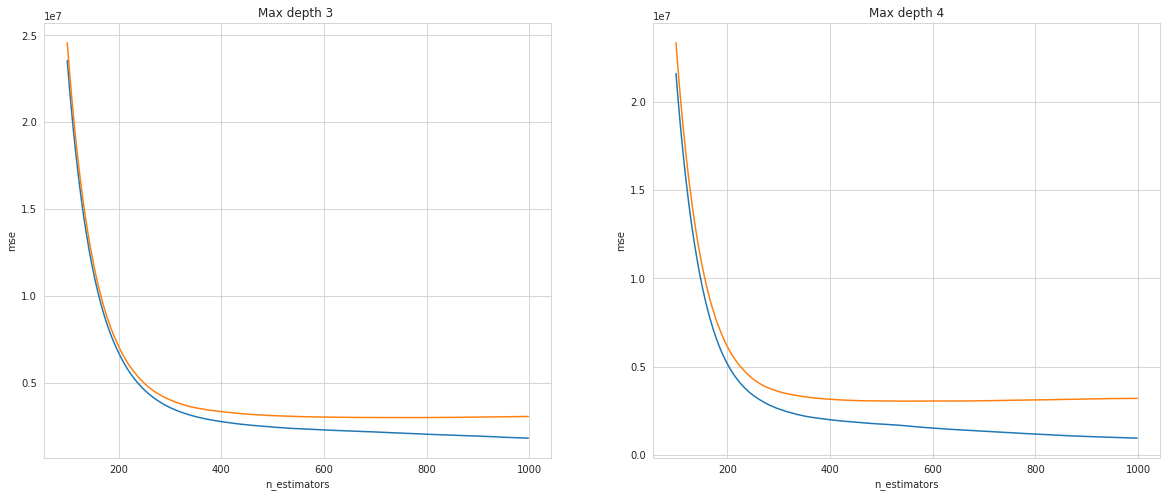

In [ ]:
estimators_plot(first_evaluete_gbr,second_evaluete_gbr)

With a maximum depth of 3 there are fewer symptoms of overfitting, that is, the model is only good for training data, while for test data it does not perform well.

A good range of estimators to select is between **320** and **360**, since from this amount the MSE does not drastically decrease for the test data, while for the training data it does decrease, which can cause an overfitting.

In [ ]:
first_evaluete_gbr.query("n_trees>=330 and n_trees<=360")

,n_trees,mse_test,mse_train
115,330,3.710098e+06,3.227366e+06
116,332,3.692500e+06,3.208361e+06
117,334,3.676926e+06,3.190123e+06
118,336,3.660602e+06,3.171630e+06
119,338,3.644864e+06,3.154494e+06
120,340,3.630640e+06,3.137665e+06
121,342,3.616476e+06,3.120526e+06
122,344,3.602911e+06,3.104378e+06
123,346,3.590603e+06,3.088128e+06
124,348,3.576738e+06,3.071852e+06



Starting from the estimator number 356 there is no longer an improvement for the test data.

In [ ]:
gbr=GradientBoostingRegressor(max_depth=3,
                          learning_rate=0.01,
                          n_estimators=356,
                          random_state=42)

In [ ]:
gbr_pipeline=pipeline_model(gbr)

In [ ]:
gbr_pipeline.fit(X_train,Y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['age', 'bmi', 'children']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['region', 'sex', 'smoker',
                                                   'medical_problem'])])),
                ('model',
                 GradientBoostingRegressor(learning_rate=0.01, n_estimators=356,
                                           random_state=42))])

In [ ]:
gbr_pipeline.score(X_train,Y_train) # evaluate with training data

0.9784300549237774

In [ ]:
gbr_pipeline.score(X_test,Y_test) # evaluate with test data

0.9759846871453317

# **XGBOOST**

It has the advantage of using GPUs for training, so it creates training faster than other algorithms.

In [ ]:
from xgboost import XGBRegressor

## *Selection number of estimators XGBOOST*

In [ ]:
def evaluate(max_depth,lr):
    
    estimator_list=[]
    mse_train_list=[]
    mse_test_list=[]
    
    estimators=np.arange(100,1000,step=2)
    for estimator in estimators:
      
        model=XGBRegressor(max_depth=max_depth,n_estimators=estimator,learning_rate=lr,random_state=42,verbosity=0)
        model=pipeline_model(model)
        model.fit(X_train,Y_train)
        pred_train=model.predict(X_train)
        pred_test=model.predict(X_test)
        
        mse_train=mean_squared_error(Y_train,pred_train)
        mse_test=mean_squared_error(Y_test,pred_test)
        
        estimator_list.append(estimator)
        mse_test_list.append(mse_test)
        mse_train_list.append(mse_train)

        
    return estimator_list,mse_test_list,mse_train_list

In [ ]:
first_evaluete_xgb=dataframe_evaluate_trees(max_depth=3,lr=0.01)

In [ ]:
second_evaluete_xgb=dataframe_evaluate_trees(max_depth=4,lr=0.01)

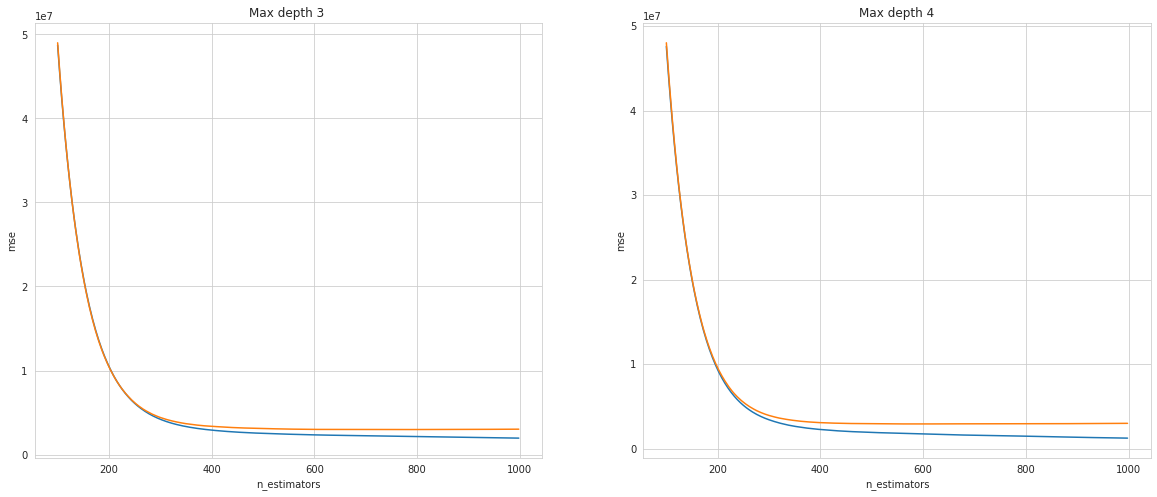

In [ ]:
estimators_plot(first_evaluete_xgb,second_evaluete_xgb)

Again with a maximum depth of 3 it will generate better results. The ideal number of trees is between **580** and **600**.Since starting from this quantity there is no significant improvement for the test data. We can allow ourselves the opportunity to use more estimators and not appreciate the curve of the overfitting graph. Something that generates a lower MSE since more decision trees were used.

In [ ]:
first_evaluete_xgb.query("n_trees>=580 and n_trees<=600")

,n_trees,mse_test,mse_train
240,580,3.010465e+06,2.374972e+06
241,582,3.008327e+06,2.370695e+06
242,584,3.006988e+06,2.368437e+06
243,586,3.005550e+06,2.365191e+06
244,588,3.004151e+06,2.362489e+06
245,590,3.003320e+06,2.359925e+06
246,592,3.002089e+06,2.357800e+06
247,594,3.000733e+06,2.355108e+06
248,596,2.999866e+06,2.351711e+06
249,598,2.999690e+06,2.349483e+06


We use a quantity of 596, since starting from this quantity there is no significant improvement. That justifies the use of more estimators.

In [ ]:
xgb_reg=XGBRegressor(max_depth=3,
                     learning_rate=0.01,
                     n_estimators=596,
                     verbosity=0,
                     random_state=42)

xgb_pipeline=pipeline_model(xgb_reg)

In [ ]:
xgb_pipeline.fit(X_train,Y_train) # train model

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['age', 'bmi', 'children']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['region', 'sex', 'smoker',
                                                   'medical_problem'])])),
                ('model',
                 XGBRegressor(learning_rate=0.01, n_estimators=596,
                              random_state=42, verbosity=0))])

In [ ]:
xgb_pipeline.score(X_train,Y_train) # evaluation with train data

0.9831619347981969

In [ ]:
xgb_pipeline.score(X_test,Y_test) # evaluation with test data

0.9795791427981901

In [ ]:
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

In [ ]:
class Evaluete():

  def __init__(self,model,X_data,y_true):

    self.X_data=X_data
    self.y_true=y_true

    self.model=model
    self.predict=self.model.predict(self.X_data)


  def mse(self):

    return mean_squared_error(self.y_true,self.predict)

  def r2(self):

    return r2_score(self.y_true,self.predict)

  def cv_score(self):
    
    return cross_val_score(self.model,self.X_data,self.y_true,cv=10).mean()
  

In [ ]:
metrics_lm_train=Evaluete(lm_pipeline,X_train,Y_train)
metrics_gbr_train=Evaluete(gbr_pipeline,X_train,Y_train)
metrics_xgb_train=Evaluete(xgb_pipeline,X_train,Y_train)

In [ ]:
metrics_lm_test=Evaluete(lm_pipeline,X_test,Y_test)
metrics_gbr_test=Evaluete(gbr_pipeline,X_test,Y_test)
metrics_xgb_test=Evaluete(xgb_pipeline,X_test,Y_test)

### **MSE**

Measures the average error between the original and predicted values.

In [ ]:


mse_lm_train=metrics_lm_train.mse()
mse_lm_test=metrics_lm_test.mse()

mse_gbr_train=metrics_gbr_train.mse()
mse_gbr_test=metrics_gbr_test.mse()

mse_xgb_train=metrics_xgb_train.mse()
mse_xgb_test=metrics_xgb_test.mse()


## **$R²$**


It measures the degree of fit between the original value and the predictions. The closer it is to 1, the closer the original and predicted values ​​will be.

In [ ]:
r2_lm_train=metrics_lm_train.r2()
r2_lm_test=metrics_lm_test.r2()

r2_gbr_train=metrics_gbr_train.r2()
r2_gbr_test=metrics_gbr_test.r2()

r2_xgb_train=metrics_xgb_train.r2()
r2_xgb_test=metrics_xgb_test.r2()


### **Cross Validation**

It measures the degree of generalization of the model. It divides the data into several subsets by the amount said by the user. To subsequently obtain the average value of generalization.

In [ ]:

cv_lm_test=metrics_lm_test.cv_score()

cv_gbr_test=metrics_gbr_test.cv_score()

cv_xgb_test=metrics_xgb_test.cv_score()

### **Dataframe evaluation**

In [ ]:
models_names=["Linear Regression","Gradient Boosting","XGBOOST"]

mse_train=[mse_lm_train,mse_gbr_train,mse_xgb_train]
mse_test=[mse_lm_test,mse_gbr_test,mse_xgb_test]

r2_train=[r2_lm_train,r2_gbr_train,r2_xgb_train]
r2_test=[r2_lm_test,r2_gbr_test,r2_xgb_test]

cv=[cv_lm_test,cv_gbr_test,cv_xgb_test]

evaluate_df=pd.DataFrame({"Model":models_names,
                          "MSE train":mse_train,
                          "MSE test":mse_test,
                          "R2 train":r2_train,
                          "R2 test":r2_test,
                          "CV":cv})

In [ ]:
evaluate_df

,Model,MSE train,MSE test,R2 train,R2 test,CV
0,Linear Regression,3.962979e+06,3.832580e+06,0.971625,0.973911,0.966669
1,Gradient Boosting,3.012596e+06,3.527899e+06,0.978430,0.975985,0.972753
2,XGBOOST,2.351711e+06,2.999866e+06,0.983162,0.979579,0.974445


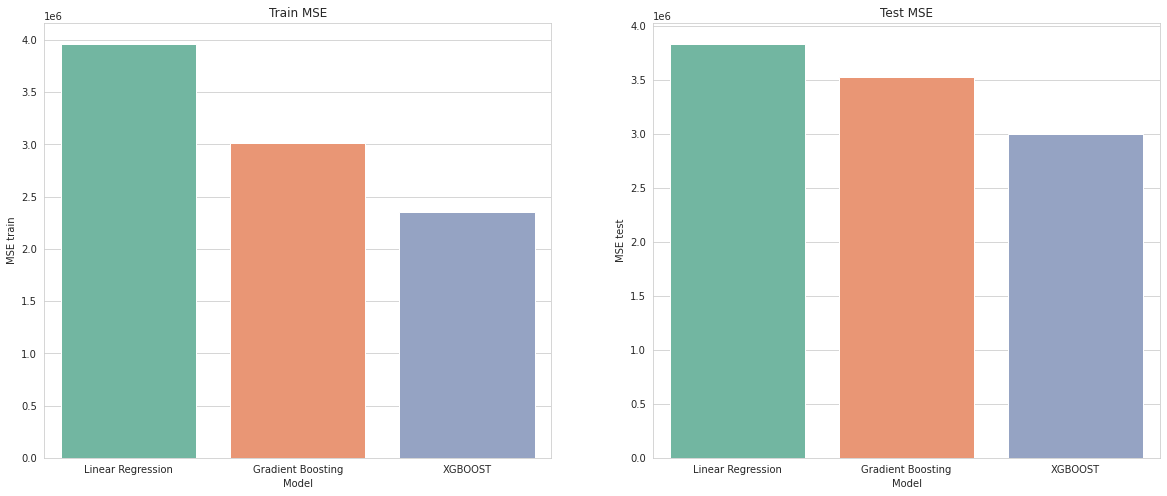

In [ ]:
fig,(ax_bar_1,ax_bar_2)=plt.subplots(1,2,figsize=(20,8))

ax_bar_1.set_title("Train MSE")
sns.barplot(data=evaluate_df,x="Model",y="MSE train",palette="Set2",ax=ax_bar_1)

ax_bar_2.set_title("Test MSE")
sns.barplot(data=evaluate_df,x="Model",y="MSE test",palette="Set2",ax=ax_bar_2)


plt.show()

The **XGBOOST** has a better RMSE for training and validation data than its competitors.

In [ ]:
pred_lm=lm_pipeline.predict(X_test)
pred_gbr=gbr_pipeline.predict(X_test)
pred_xgb=xgb_pipeline.predict(X_test)

In [ ]:

df_test=pd.DataFrame({"true_values":Y_test,
                        "pred_lm":pred_lm,
                      "pred_gbr":pred_gbr,
                      "pred_xgb":pred_xgb,
                      "smoker":X_test["smoker"]
                     })

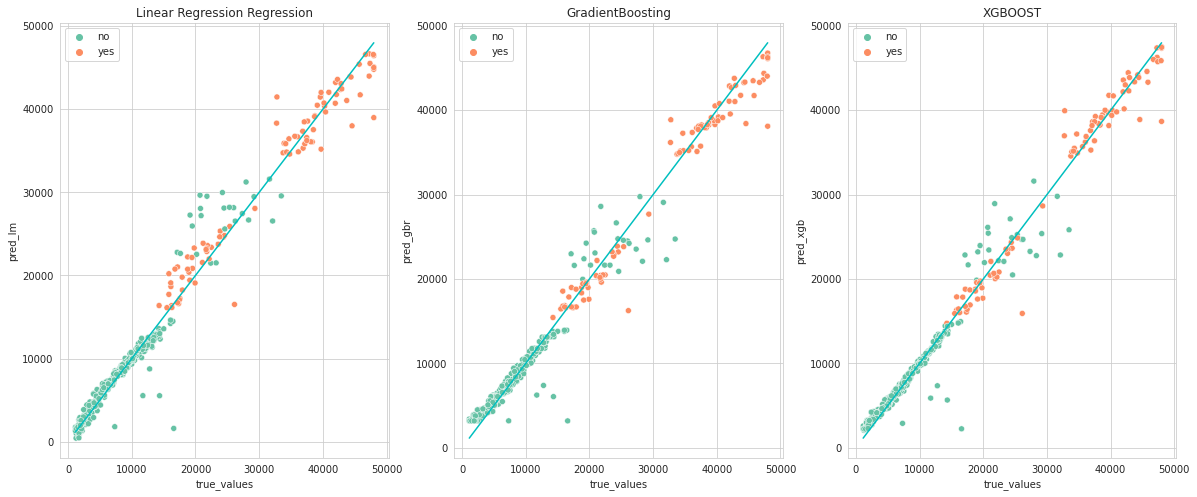

In [ ]:
fig,(ax_0,ax_1,ax_2)=plt.subplots(1,3,figsize=(20,8))
sns.set_style(style="whitegrid")

ax_0.set_title("Linear Regression Regression")
sns.scatterplot(data=df_test,x="true_values",y="pred_lm",color="red",hue="smoker",ax=ax_0,palette="Set2")
sns.lineplot(data=df_test,x="true_values",y="true_values",color="c",ax=ax_0)


ax_1.set_title("GradientBoosting")
sns.scatterplot(data=df_test,x="true_values",y="pred_gbr",color="red",hue="smoker",ax=ax_1,palette="Set2")
sns.lineplot(data=df_test,x="true_values",y="true_values",color="c",ax=ax_1)

ax_2.set_title("XGBOOST")
sns.scatterplot(data=df_test,x="true_values",y="pred_xgb",color="red",hue="smoker",ax=ax_2,palette="Set2")
sns.lineplot(data=df_test,x="true_values",y="true_values",color="c",ax=ax_2)

plt.show()

## **Conclusion** 

All 3 algorithms give excellent results. Any of them can perfectly solve the problem.

**XGBOOST** Offers better metrics for test and training data.It also has the advantage that it does not require scaling for continuous variables, since it works based on mathematical inequalities. We can use the original data without any problem. 